# SAMPIC Noise Filtering & Average Shape

Use this notebook to identify and remove purely noisy waveforms from SAMPIC data, inspect summary statistics, and visualise the aggregate shape of the remaining signals.

## Workflow

1. Load the unpacked ROOT file and required libraries.
2. Classify each hit waveform using configurable noise rejection criteria.
3. Report statistics (overall and per channel) on filtered vs retained hits.
4. Visualise channel-level filtering and build a 2D heatmap plus average waveform for the surviving signals.

Tune the thresholds in the **Filtering Parameters** cell to match your dataset.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25
plt.rcParams['font.size'] = 12

In [2]:
DATA_FILE = os.getenv('SAMPIC_OUTPUT', '../../output.root')
LIB_DIR = '../../build/lib'
LIBS_TO_LOAD = [
    'libanalysis_pipeline_core.so',
    'libunpacker_data_products_core.so',
    'libunpacker_data_products_sampic.so',
]

for lib in LIBS_TO_LOAD:
    path = os.path.join(LIB_DIR, lib)
    if os.path.exists(path):
        ROOT.gSystem.Load(path)
    else:
        print(f'Warning: {lib} not found in {LIB_DIR}')

In [3]:
file = ROOT.TFile.Open(DATA_FILE)
if not file or file.IsZombie():
    raise RuntimeError(f'Unable to open ROOT file: {DATA_FILE}')

tree = file.Get('events')
if not tree:
    raise RuntimeError("Tree 'events' not found in file")

print(f'Total events available: {tree.GetEntries()}')
print('Branches:', [branch.GetName() for branch in tree.GetListOfBranches()])

Total events available: 85135
Branches: ['sampic_event', 'sampic_event_timing', 'sampic_collector_timing', 'has_sampic_collector_timing']


## Filtering Parameters

Adjust these thresholds to control how aggressively noise is removed. By default we treat a waveform as noise when:

- Its dynamic range (max - min) stays below `AMP_THRESHOLD` **and** the stored peak is small.
- Its sample-to-sample variation is tiny (`STD_THRESHOLD`).
- Its time-over-threshold metric is essentially zero (`TOT_THRESHOLD`).
- Waveforms dropping below `-NEGATIVE_DIP_THRESHOLD` (after baseline subtraction) are flagged for inspection but kept in the retained set.

All surviving waveforms are baseline-subtracted before building the heatmap/averages.

`Time-over-Threshold (TOT)` is the duration (in ns) the signal stays above a hardware threshold. Some datasets leave this at zero, so the notebook only uses the TOT cut when a positive value is present.

In [4]:
AMP_THRESHOLD = 400.0       # ADC counts
PEAK_THRESHOLD = 1600.0      # ADC counts
STD_THRESHOLD = 2.0        # ADC counts
TOT_THRESHOLD = -1         # ns (we dont' get TOT data, it's always 0)
NEGATIVE_DIP_THRESHOLD = 60.0   # ADC counts below baseline to flag undershoot
MAX_EVENTS = None          # Set to an integer to limit the scan (e.g. 5000)
BASELINE_SAMPLES = 8       # Samples used to estimate the baseline per waveform

print('Filtering thresholds set – adjust as needed and re-run downstream cells if you change them.')

Filtering thresholds set – adjust as needed and re-run downstream cells if you change them.


In [5]:
def extract_waveform(hit):
    """Return waveform samples as a numpy array of floats."""
    wf = hit.corrected_waveform
    return np.array([wf[i] for i in range(len(wf))], dtype=np.float32)


def classify_hit(hit):
    waveform = extract_waveform(hit)
    if waveform.size == 0:
        return waveform, {
            'amplitude': 0.0,
            'peak': 0.0,
            'tot': getattr(hit, 'tot_value', 0.0),
            'std': 0.0,
            'min_value': 0.0,
            'has_negative_dip': False,
            'is_noise': True,
        }

    baseline = waveform[:BASELINE_SAMPLES].mean() if waveform.size >= BASELINE_SAMPLES else waveform.mean()
    centered = waveform - baseline
    amplitude = float(centered.max() - centered.min())
    peak = float(getattr(hit, 'peak', centered.max()))
    tot_raw = getattr(hit, 'tot_value', None)
    tot = float(tot_raw) if tot_raw is not None else float('nan')
    std = float(centered.std())
    min_value = float(centered.min())

    core_noise = (amplitude < AMP_THRESHOLD and abs(peak) < PEAK_THRESHOLD and std < STD_THRESHOLD)
    tot_measured = not np.isnan(tot) and tot > 0.0
    if tot_measured:
        noise_like = core_noise and tot <= TOT_THRESHOLD
    else:
        noise_like = core_noise

    has_negative_dip = min_value < -NEGATIVE_DIP_THRESHOLD

    return centered, {
        'amplitude': amplitude,
        'peak': peak,
        'tot': tot if not np.isnan(tot) else None,
        'std': std,
        'min_value': min_value,
        'has_negative_dip': has_negative_dip,
        'is_noise': noise_like,
    }


In [6]:
summary = {
    'events_scanned': 0,
    'total_hits': 0,
    'noise_hits': 0,
    'negative_hits': 0,
}
channel_stats = defaultdict(lambda: {'total': 0, 'noise': 0, 'negative': 0})
non_noise_waveforms = []
non_noise_channels = []
non_noise_amplitudes = []
non_noise_tot = []
negative_waveforms = []
negative_info = []

entries = tree.GetEntries() if MAX_EVENTS is None else min(MAX_EVENTS, tree.GetEntries())

for idx in range(entries):
    tree.GetEntry(idx)
    summary['events_scanned'] += 1
    event = tree.sampic_event
    for hit_idx, hit in enumerate(event.hits):
        waveform, stats = classify_hit(hit)
        ch = int(hit.channel)
        summary['total_hits'] += 1
        channel_stats[ch]['total'] += 1

        if stats['is_noise']:
            summary['noise_hits'] += 1
            channel_stats[ch]['noise'] += 1
            continue

        non_noise_waveforms.append(waveform)
        non_noise_channels.append(ch)
        non_noise_amplitudes.append(stats['amplitude'])
        non_noise_tot.append(stats['tot'])

        if stats['has_negative_dip']:
            summary['negative_hits'] += 1
            channel_stats[ch]['negative'] += 1
            negative_waveforms.append(waveform)
            negative_info.append({
                'event': idx,
                'hit': hit_idx,
                'channel': ch,
                'min_value': stats['min_value'],
                'amplitude': stats['amplitude'],
                'peak': stats['peak'],
            })

print(f"Processed {summary['events_scanned']} events")
print(f"Total hits inspected: {summary['total_hits']}")
retained = summary['total_hits'] - summary['noise_hits']
print(f"Retained hits: {retained}")
print(f"Noise-like hits filtered: {summary['noise_hits']} ({summary['noise_hits']/max(summary['total_hits'],1):.2%})")
if retained:
    print(f"Hits with baseline undershoot (< -{NEGATIVE_DIP_THRESHOLD} ADC): {summary['negative_hits']} ({summary['negative_hits']/retained:.2%})")
else:
    print("Hits with baseline undershoot: n/a (no retained hits)")


Processed 85135 events
Total hits inspected: 467871
Noise-like hits filtered: 1120 (0.24%)


In [7]:
channels = sorted(channel_stats.keys())
print(f"Channels seen: {channels}")
print('
Per-channel summary:')
print(f"{'Ch':>3} | {'Hits':>6} | {'Filtered':>8} | {'Retained':>8} | {'Under BL':>9} | {'Under %':>8}")
print('-' * 70)
for ch in channels:
    totals = channel_stats[ch]
    filtered = totals['noise']
    retained = totals['total'] - filtered
    negative = totals['negative']
    frac = (filtered / totals['total']) if totals['total'] else 0.0
    neg_frac = (negative / retained) if retained else 0.0
    print(f"{ch:>3d} | {totals['total']:>6d} | {filtered:>8d} | {retained:>8d} | {negative:>9d} | {neg_frac:>7.1%}")


Channels seen: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

Per-channel summary:
 Ch |   Hits | Filtered | Retained | Filtered %
------------------------------------------------
  0 |   7293 |        0 |     7293 |      0.0%
  1 |   7293 |        0 |     7293 |      0.0%
  2 |   7293 |        0 |     7293 |      0.0%
  3 |   7293 |        0 |     7293 |      0.0%
  4 |   7293 |        0 |     7293 |      0.0%
  5 |   7293 |        0 |     7293 |      0.0%
  6 |   7293 |        0 |     7293 |      0.0%
  7 |   7293 |        0 |     7293 |      0.0%
  8 |   7293 |        0 |     7293 |      0.0%
  9 |   7293 |        0 |     7293 |      0.0%
 10 |   7293 |        0 |     7293 |      0.0%
 11 |   7293 |        0 |     7293 |      0.0%
 12 |   7293 |        0 |     7293 |      0.0%
 13 |   

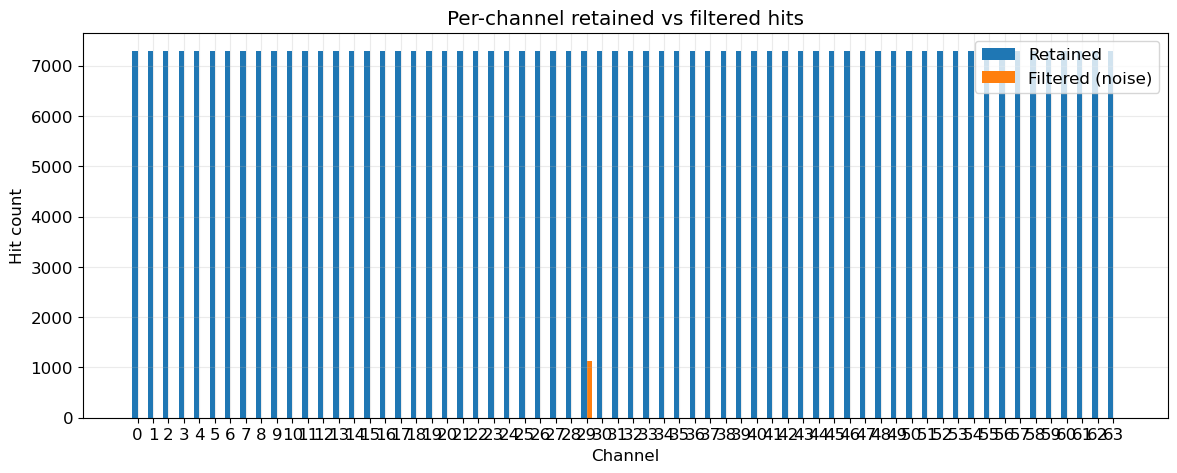

In [8]:
if channels:
    filtered_counts = [channel_stats[ch]['noise'] for ch in channels]
    retained_counts = [channel_stats[ch]['total'] - channel_stats[ch]['noise'] for ch in channels]
    negative_counts = [channel_stats[ch]['negative'] for ch in channels]

    x = np.arange(len(channels))
    width = 0.3

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.bar(x - width, retained_counts, width, label='Retained', color='tab:blue')
    ax.bar(x, filtered_counts, width, label='Filtered (noise)', color='tab:orange')
    ax.bar(x + width, negative_counts, width, label='Retained w/ undershoot', color='tab:red')
    ax.set_xticks(x)
    ax.set_xticklabels(channels)
    ax.set_xlabel('Channel')
    ax.set_ylabel('Hit count')
    ax.set_title('Channel-wise hit breakdown')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No channels found – check filtering thresholds or input file.')


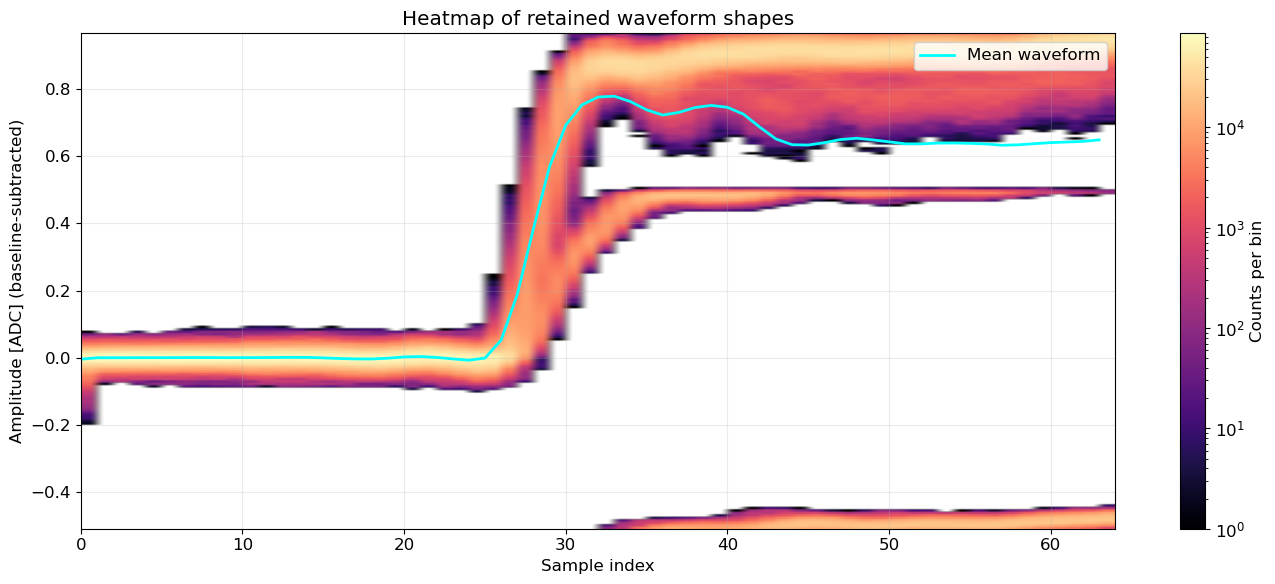

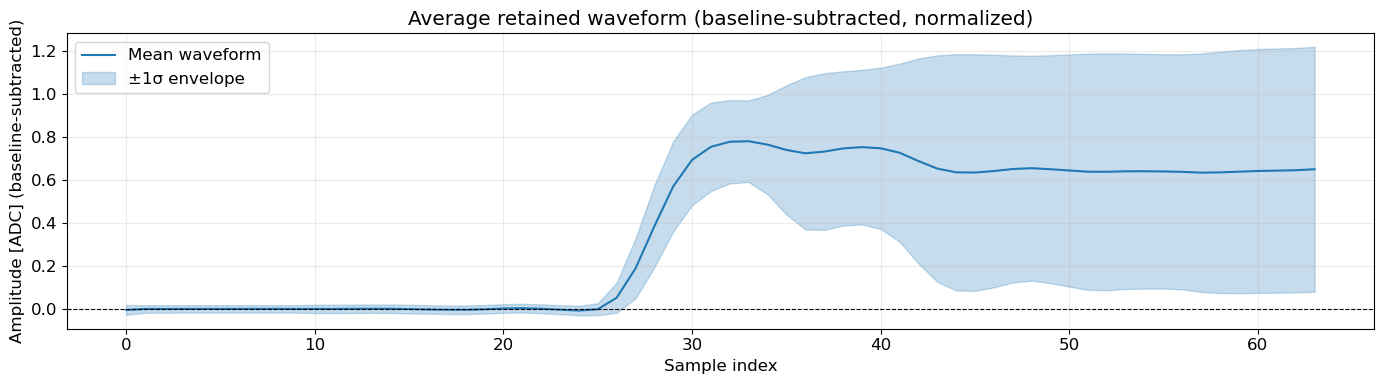

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

if non_noise_waveforms:
    lengths = [len(wf) for wf in non_noise_waveforms]
    min_len = min(lengths)
    if min_len == 0:
        raise RuntimeError("Encountered zero-length waveform; cannot build heatmap.")

    # --- Baseline subtraction and optional normalization ---
    baseline_samples = 10  # use first N samples as baseline reference
    normalize = True

    processed = []
    for wf in non_noise_waveforms:
        wf = wf[:min_len]
        wf = wf - np.mean(wf[:baseline_samples])  # baseline subtract
        if normalize:
            amp_range = np.ptp(wf) + 1e-6  # avoid div by zero
            wf = wf / amp_range
        processed.append(wf)
    trimmed = np.stack(processed)

    # --- Flatten for histogram ---
    sample_indices = np.tile(np.arange(min_len), trimmed.shape[0])
    values = trimmed.reshape(-1)

    v_min, v_max = np.percentile(values, [0.5, 99.5])
    bins = [min_len, 200]
    hist, xedges, yedges = np.histogram2d(
        sample_indices, values, bins=bins, range=[[0, min_len], [v_min, v_max]]
    )

    # --- Heatmap ---
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(
        hist.T,
        origin="lower",
        aspect="auto",
        extent=[0, min_len, yedges[0], yedges[-1]],
        cmap="magma",
        norm=LogNorm(vmin=1, vmax=hist.max())
    )
    fig.colorbar(im, ax=ax, label="Counts per bin")
    ax.set_xlabel("Sample index")
    ax.set_ylabel("Amplitude [ADC] (baseline-subtracted)")
    ax.set_title("Heatmap of retained waveform shapes")

    # --- Mean waveform (same scale as heatmap) ---
    mean_wave = trimmed.mean(axis=0)
    std_wave = trimmed.std(axis=0)
    ax.plot(np.arange(min_len), mean_wave, color="cyan", lw=2, label="Mean waveform")
    ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # --- Average waveform ±1σ envelope ---
    fig, ax = plt.subplots(figsize=(14, 4))
    x = np.arange(min_len)
    ax.plot(x, mean_wave, color="tab:blue", label="Mean waveform")
    ax.fill_between(x, mean_wave - std_wave, mean_wave + std_wave,
                    color="tab:blue", alpha=0.25, label="±1σ envelope")
    ax.axhline(0, color="k", lw=0.8, ls="--")
    ax.set_xlabel("Sample index")
    ax.set_ylabel("Amplitude [ADC] (baseline-subtracted)")
    ax.set_title("Average retained waveform (baseline-subtracted, normalized)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No non-noise waveforms collected – relax thresholds or check data file.")


## Baseline undershoot inspection

In [ ]:
if summary['negative_hits']:
    print(f"Waveforms flagged with baseline undershoot (< -{NEGATIVE_DIP_THRESHOLD} ADC): {summary['negative_hits']}")
    preview_count = min(10, summary['negative_hits'])
    print(f"Showing first {preview_count} entries (event, hit, channel, min ADC, peak, amplitude):")
    for entry in negative_info[:preview_count]:
        print(f"  event {entry['event']}, hit {entry['hit']}, ch {entry['channel']} | "
              f"min {entry['min_value']:.1f}, peak {entry['peak']:.1f}, amp {entry['amplitude']:.1f}")
else:
    print('No baseline undershoots detected with current threshold.')


In [ ]:
def plot_negative_examples(max_examples=4):
    if not negative_waveforms:
        print('No negative-dip waveforms to plot.')
        return
    n = min(max_examples, len(negative_waveforms))
    fig, axes = plt.subplots(n, 1, figsize=(14, 3 * n), sharex=True)
    if n == 1:
        axes = [axes]
    for ax, wf, meta in zip(axes, negative_waveforms[:n], negative_info[:n]):
        ax.plot(wf, color='tab:red')
        ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
        ax.set_ylabel('ADC')
        ax.set_title(f"Event {meta['event']} | Hit {meta['hit']} | Ch {meta['channel']} | min {meta['min_value']:.1f} ADC")
    axes[-1].set_xlabel('Sample index')
    plt.tight_layout()
    plt.show()

plot_negative_examples()


In [ ]:
if negative_waveforms:
    lengths = [len(wf) for wf in negative_waveforms]
    min_len = min(lengths)
    trimmed = np.stack([wf[:min_len] for wf in negative_waveforms])

    sample_indices = np.tile(np.arange(min_len), trimmed.shape[0])
    values = trimmed.reshape(-1)
    v_min, v_max = np.percentile(values, [0.5, 99.5])
    bins = [min_len, 200]
    hist, xedges, yedges = np.histogram2d(
        sample_indices, values, bins=bins, range=[[0, min_len], [v_min, v_max]]
    )

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(
        hist.T,
        origin='lower',
        aspect='auto',
        extent=[0, min_len, yedges[0], yedges[-1]],
        cmap='coolwarm'
    )
    fig.colorbar(im, ax=ax, label='Counts per bin')
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Amplitude [ADC] (baseline-subtracted)')
    ax.set_title('Heatmap of undershooting waveforms')
    plt.tight_layout()
    plt.show()
else:
    print('No undershooting waveforms available for heatmap.')
